In [1]:
import CMGDB

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np
import math

First we run the code using a map defined in the C++ code. In this example
the map is the Leslie map. First we define parameters for the code.

In [2]:
subdiv_min = 20 # Min number of subdivision of phase space
subdiv_max = 20 # Max number of subdivision of phase space
lower_bounds = [-0.001, -0.001] # Lower bounds of the bounding box in phase space
upper_bounds = [90.0, 70.0] # Upper bounds of the bounding box in phase space
params = [19.6, 23.68] # Parameter for Leslie map

morse_fname = 'morse.csv' # File name to save Morse sets

Next we run the code using to compute the Morse sets using the parameter defined above.

In [3]:
%%time
morse_graph = CMGDB.MorseGraphIntvalMap(subdiv_min, subdiv_max, lower_bounds,
                                        upper_bounds, params, morse_fname)

Compute_Morse_Graph. Initializing root MorseDecomposition
Compute_Morse_Graph. A phase_space -> size () == 1
CPU times: user 642 ms, sys: 58.8 ms, total: 701 ms
Wall time: 716 ms
Compute_Morse_Graph. B phase_space -> size () == 89979
Total Grid Memory (can be external) = 7075226
Max Memory For Single Grid (must be internal)= 2486610
Max SCC Random Access memory use (must be internal)= 550477
Max SCC stack memory use (can be external memory) = 1392664
 ---- SUMMARY ---- 
Internal Memory Requirement = 3037087
External Memory Requirement = 8467890
Max graph memory size (never stored, however) = 6037072
Total Time for Finding Morse Sets and reachability relation: : 

Plot the Morse graph.

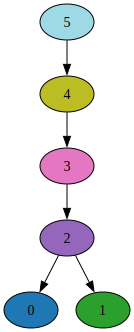

In [4]:
CMGDB.PlotMorseGraph(morse_graph)

The Morse sets are saved in the file specified above. Load this file and plot the Morse sets.

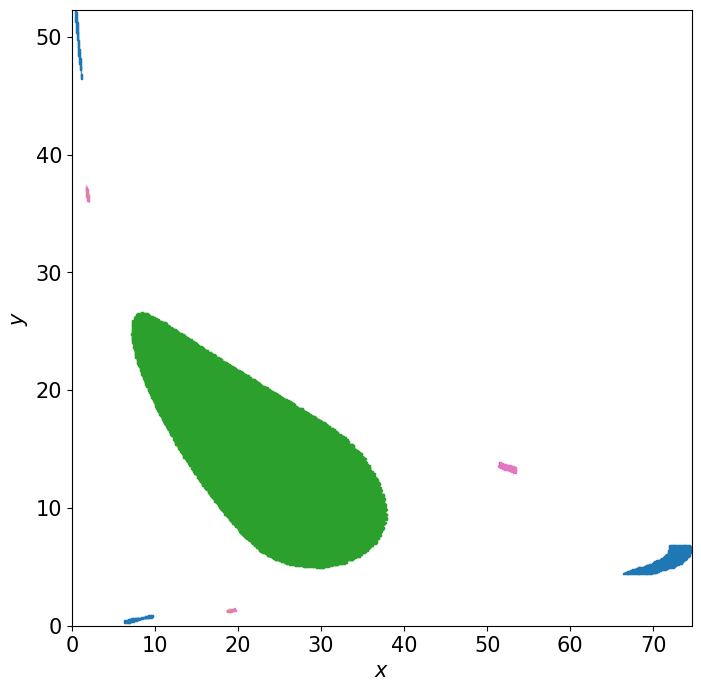

In [5]:
morse_sets = CMGDB.LoadMorseSetFile(morse_fname)

CMGDB.PlotMorseSets(morse_sets)

## Comparison with MorseGraph Package

Now let's compute the same analysis using the new MorseGraph package and compare the results and timing.

In [7]:
# Import MorseGraph components
from MorseGraph.grids import UniformGrid
from MorseGraph.dynamics import BoxMapFunction
from MorseGraph.core import Model
from MorseGraph.analysis import compute_morse_graph, compute_all_morse_set_basins
from MorseGraph.plot import plot_morse_sets, plot_morse_graph, plot_basins_of_attraction
from MorseGraph.systems import leslie_map

Set up the same domain and grid configuration as CMGDB, but using MorseGraph's UniformGrid.

In [8]:
# Same configuration as CMGDB for comparison
# CMGDB uses subdiv_min=20, subdiv_max=30, which means 2^10 in each direction min, and 2^15 max.
DOMAIN = np.array([[-0.001, -0.001], [90.0, 70.0]])
GRID_RESOLUTION = 10 
EPSILON_BLOAT = 0.01

In [9]:
# Create the dynamics object using the Leslie map from MorseGraph.systems
dynamics_mg = BoxMapFunction(leslie_map, epsilon=EPSILON_BLOAT)

# Create a grid
divisions = np.array([2**GRID_RESOLUTION, 2**GRID_RESOLUTION], dtype=int)
grid_mg = UniformGrid(bounds=DOMAIN, divisions=divisions)

# Create the model
model_mg = Model(grid_mg, dynamics_mg)

print(f"MorseGraph: Created grid with {len(grid_mg.get_boxes())} boxes")
print(f"Domain: {DOMAIN}")

MorseGraph: Created grid with 1048576 boxes
Domain: [[-1.e-03 -1.e-03]
 [ 9.e+01  7.e+01]]


Compute the BoxMap and Morse graph using MorseGraph package, with timing.

In [10]:
%%time
# Compute BoxMap
box_map_mg = model_mg.compute_box_map()
print(f"BoxMap has {len(box_map_mg.nodes())} nodes and {len(box_map_mg.edges())} edges")

BoxMap has 1048576 nodes and 4414978 edges
CPU times: user 6min 31s, sys: 7.49 s, total: 6min 38s
Wall time: 6min 41s


In [12]:
%%time
# Compute Morse graph
morse_graph_mg = compute_morse_graph(box_map_mg)
print(f"Morse graph has {len(morse_graph_mg.nodes())} Morse sets")

# Print details of Morse sets
for i, morse_set in enumerate(morse_graph_mg.nodes()):
    print(f"  Morse set {i+1}: {len(morse_set)} boxes")

Morse graph has 6 Morse sets
  Morse set 1: 48746 boxes
  Morse set 2: 376 boxes
  Morse set 3: 4 boxes
  Morse set 4: 119 boxes
  Morse set 5: 8 boxes
  Morse set 6: 1 boxes
CPU times: user 6.94 s, sys: 112 ms, total: 7.05 s
Wall time: 7.05 s


Visualize the results using MorseGraph plotting functions.

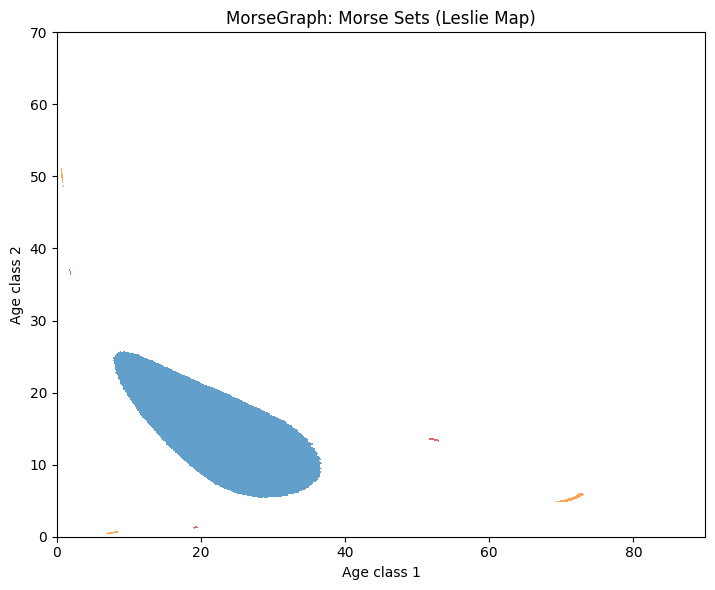

In [13]:
# Plot Morse sets
fig, ax = plt.subplots(figsize=(10, 6))
plot_morse_sets(grid_mg, morse_graph_mg, ax=ax, cmap=matplotlib.cm.cool)
ax.set_title("MorseGraph: Morse Sets (Leslie Map)")
ax.set_xlabel("Age class 1")
ax.set_ylabel("Age class 2")
plt.tight_layout()
plt.show()

/Users/bdoprad/Work/Code/Active/MorseGraph/.venv/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0) is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


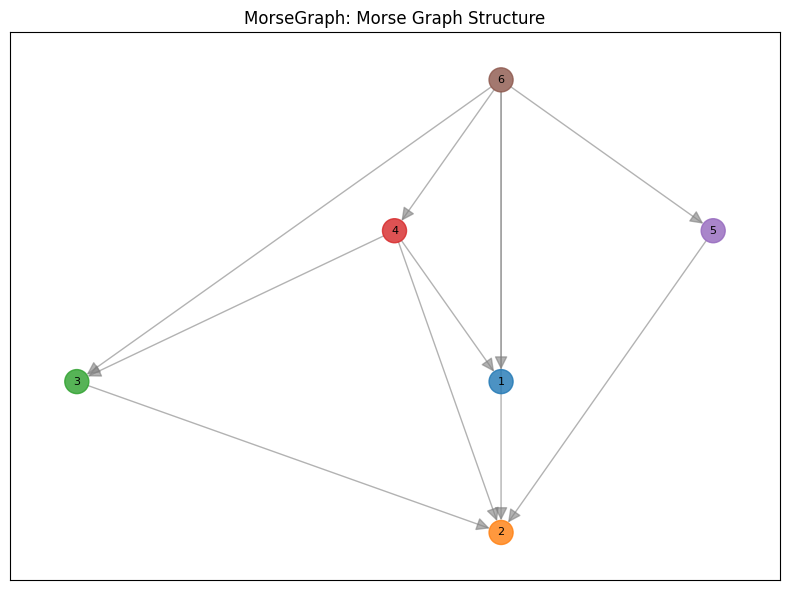

In [14]:
# Plot Morse Graph
fig, ax = plt.subplots(figsize=(8, 6))
plot_morse_graph(morse_graph_mg, ax=ax)
ax.set_title("MorseGraph: Morse Graph Structure")
plt.tight_layout()
plt.show()

In [ ]:
%%time
basins_mg = compute_all_morse_set_basins(morse_graph_mg, box_map_mg)
print(f"Computed basins for {len(basins_mg)} Morse sets")
# # Plot Basins of Attraction
fig, ax = plt.subplots(figsize=(10, 6))
plot_basins_of_attraction(grid_mg, basins_mg, morse_graph=morse_graph_mg, 
                          ax=ax, show_outside=True, cmap=matplotlib.cm.cool)
ax.set_title("MorseGraph: Basins of Attraction")
ax.set_xlabel("Age class 1")
ax.set_ylabel("Age class 2")
plt.tight_layout()
plt.show()

In the next example we run the code again with the Leslie map, but this time we define
the map as a Python function and pass that function to the C++ code.

In [ ]:
# Leslie map withou padding

def f(x):
    th1 = 19.6
    th2 = 23.68
    return [(th1 * x[0] + th2 * x[1]) * math.exp (-0.1 * (x[0] + x[1])), 0.7 * x[0]]

def F(rect):
    x0_min = rect[0]
    x1_min = rect[1]
    x0_max = rect[2]
    x1_max = rect[3]
    y1 = f([x0_min, x1_min])
    y2 = f([x0_max, x1_min])
    y3 = f([x0_min, x1_max])
    y4 = f([x0_max, x1_max])
    y0_min = min([y1[0], y2[0], y3[0], y4[0]])
    y0_max = max([y1[0], y2[0], y3[0], y4[0]])
    y1_min = min([y1[1], y2[1], y3[1], y4[1]])
    y1_max = max([y1[1], y2[1], y3[1], y4[1]])
    return [y0_min, y1_min, y0_max, y1_max]

In [ ]:
# Define de parameters for this map
subdiv_min = 20
subdiv_max = 30
lower_bounds = [-0.001, -0.001]
upper_bounds = [90.0, 70.0]

morse_fname = 'morse.csv'

In [ ]:
%%time
morse_graph = CMGDB.MorseGraphMap(subdiv_min, subdiv_max, lower_bounds,
                                  upper_bounds, morse_fname, F)

CPU times: user 3.62 s, sys: 353 ms, total: 3.97 s
Wall time: 4.16 s


We can select a colormap to plot the Morse graph and the Morse sets. It is important to select the same colormap for the Morse graph and the Morse sets so they have matching colors.

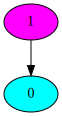

In [ ]:
CMGDB.PlotMorseGraph(morse_graph, cmap=matplotlib.cm.cool)

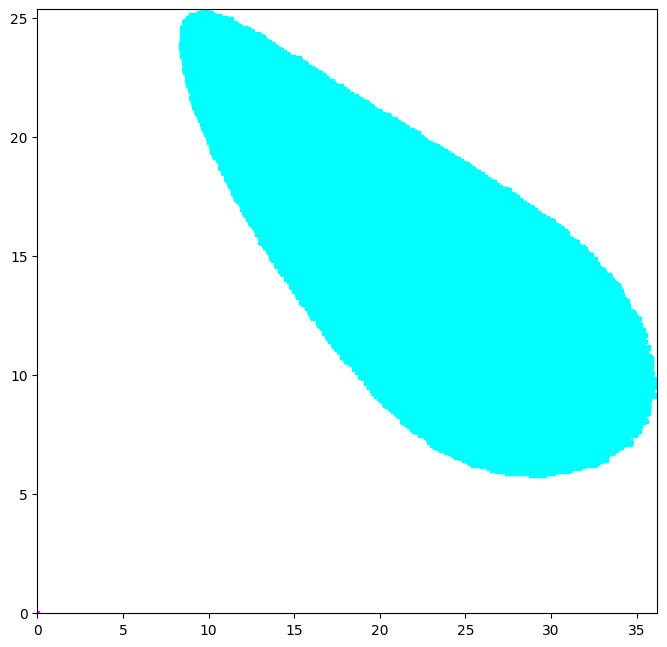

In [ ]:
# We can just pass the file name to plot the Morse sets
CMGDB.PlotMorseSets(morse_fname, cmap=matplotlib.cm.cool)

In [ ]:
# Leslie map with padding

def f(x):
    th1 = 19.6
    th2 = 23.68
    return [(th1 * x[0] + th2 * x[1]) * math.exp (-0.1 * (x[0] + x[1])), 0.7 * x[0]]

def F(rect):
    x0_min = rect[0]
    x1_min = rect[1]
    x0_max = rect[2]
    x1_max = rect[3]
    h_x0 = x0_max - x0_min
    h_x1 = x1_max - x1_min
    y1 = f([x0_min, x1_min])
    y2 = f([x0_max, x1_min])
    y3 = f([x0_min, x1_max])
    y4 = f([x0_max, x1_max])
    y0_min = min([y1[0], y2[0], y3[0], y4[0]]) - h_x0
    y0_max = max([y1[0], y2[0], y3[0], y4[0]]) + h_x0
    y1_min = min([y1[1], y2[1], y3[1], y4[1]]) - h_x1
    y1_max = max([y1[1], y2[1], y3[1], y4[1]]) + h_x1
    return [y0_min, y1_min, y0_max, y1_max]

In [ ]:
# Define de parameters for this map
subdiv_min = 20
subdiv_max = 30
lower_bounds = [-0.001, -0.001]
upper_bounds = [90.0, 70.0]

morse_fname = 'morse_2.csv'

In [ ]:
%%time
morse_graph = CMGDB.MorseGraphMap(subdiv_min, subdiv_max, lower_bounds,
                                  upper_bounds, morse_fname, F)

CPU times: user 8.17 s, sys: 499 ms, total: 8.67 s
Wall time: 9.3 s


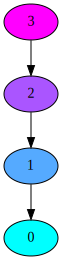

In [ ]:
CMGDB.PlotMorseGraph(morse_graph, cmap=matplotlib.cm.cool)

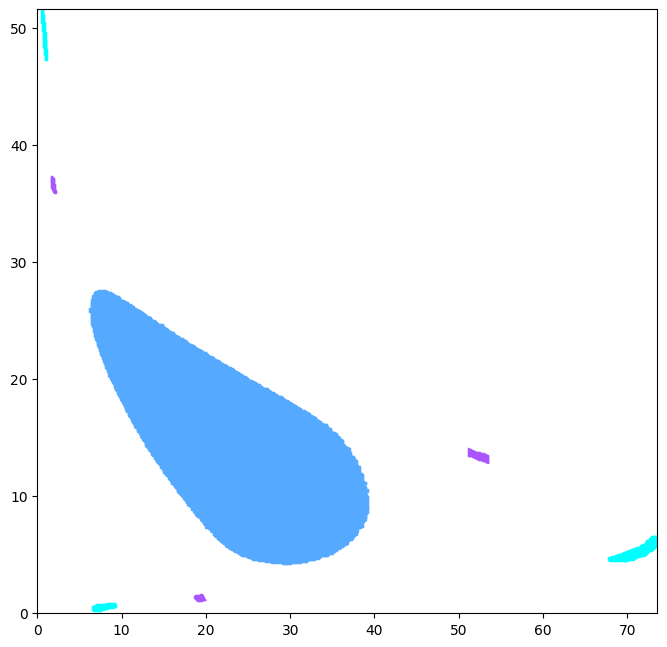

In [ ]:
CMGDB.PlotMorseSets(morse_fname, cmap=matplotlib.cm.cool)